In [34]:
# %% ============================================================
# 🧱 NYC Construction Incident Risk Analysis
# 建筑事故风险与气候、热脆弱性相关性分析
# Team ZZDD | 2025-10
# ============================================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

sns.set(style="whitegrid")

# %% ============================================================
# 1️⃣ Load & Clean Incident Data
# 载入并清理建筑事故数据
# ============================================================

df = pd.read_csv("Construction_Related_Incidents(Construction-Related_Incidents).csv")

# 日期转换与重复项删除 get rid of repeat items and date transfer
df["Incident Date"] = pd.to_datetime(df["Incident Date"], errors="coerce")
df = df.drop_duplicates(subset=["Accident Report ID"])

# pick date
df["Year"] = df["Incident Date"].dt.year
df["Month"] = df["Incident Date"].dt.month

In [35]:
# %% ============================================================
# 2️⃣ Merge Heat Vulnerability Index (HVI)
# 合并纽约市热脆弱性指数数据
# ============================================================

hvi = pd.read_csv("Heat_Vulnerability_Index_Rankings.csv")
df.columns = df.columns.str.strip()
hvi.columns = hvi.columns.str.strip()

# normalized postcode
df["Postcode"] = df["Postcode"].astype(str).str[:5]
hvi["ZIP Code Tabulation Area (ZCTA) 2020"] = (
    hvi["ZIP Code Tabulation Area (ZCTA) 2020"].astype(str).str[:5]
)

# combine HVI
df = pd.merge(
    df,
    hvi[["ZIP Code Tabulation Area (ZCTA) 2020", "Heat Vulnerability Index (HVI)"]],
    left_on="Postcode", right_on="ZIP Code Tabulation Area (ZCTA) 2020", how="left"
)

# delete repeated item
df.drop(columns=[c for c in df.columns if "ZIP Code Tabulation Area" in c], inplace=True)
df.rename(columns={"Heat Vulnerability Index (HVI)": "HVI"}, inplace=True)

In [36]:
# %% ============================================================
# 3️⃣ Merge Climate Data (Temperature & Precipitation)
# 合并纽约市月均气温与降水量数据
# ============================================================

temp = pd.read_csv("New_York_City_Climate_Projections__Temperature_and_Precipitation.csv")
temp.columns = temp.columns.str.strip()

# pick month
valid_months = [
    "January","February","March","April","May","June",
    "July","August","September","October","November","December"
]
temp = temp[temp["Month/Period"].isin(valid_months)]
temp = temp[temp["Year"].astype(str).str.contains("Baseline", case=False, na=False)]

# temperature and precipitation
for col in ["Mean Temperature", "Mean Precipitation"]:
    temp[col] = (
        temp[col].astype(str)
        .str.replace("掳", "", regex=False)
        .str.replace("°", "", regex=False)
        .str.extract(r"(\d+\.?\d*)")
        .astype(float)
    )

# relation between month and number
month_map = {
    "January":1,"February":2,"March":3,"April":4,"May":5,"June":6,
    "July":7,"August":8,"September":9,"October":10,"November":11,"December":12
}
temp["Month"] = temp["Month/Period"].map(month_map)
temp = temp.sort_values("Month").drop_duplicates(subset=["Month"], keep="first")

# mapping
df["AvgTemp"]   = df["Month"].map(dict(zip(temp["Month"], temp["Mean Temperature"])))
df["AvgPrecip"] = df["Month"].map(dict(zip(temp["Month"], temp["Mean Precipitation"])))

# 限定分析时间范围（2024–2025年1–9月）figure out the time interval
mask = (df["Incident Date"] >= "2024-01-01") & (df["Incident Date"] < "2025-10-01")
df = df[mask]

In [37]:
# %% ============================================================
# 4️⃣ Construct Severity Index
# 构造事故严重度指标
# ============================================================

df["SeverityIndex"] = 10 * df["Fatality"] + 2 * df["Injury"]
df["SeverityIndex"] = (
    (df["SeverityIndex"] - df["SeverityIndex"].min()) /
    (df["SeverityIndex"].max() - df["SeverityIndex"].min())
)

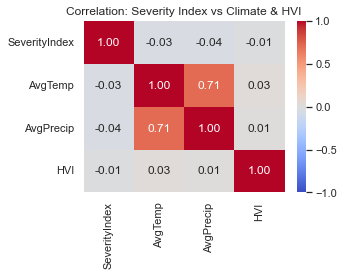

✅ Global Pearson Correlation Coefficients:
               SeverityIndex  AvgTemp  AvgPrecip    HVI
SeverityIndex          1.000   -0.034     -0.038 -0.008
AvgTemp               -0.034    1.000      0.707  0.029
AvgPrecip             -0.038    0.707      1.000  0.010
HVI                   -0.008    0.029      0.010  1.000


In [38]:
# %% ============================================================
# 5️⃣ Global Correlation Analysis
# 全局相关性分析
# ============================================================

corr_vars = ["SeverityIndex", "AvgTemp", "AvgPrecip", "HVI"]
corr = df[corr_vars].corr()

plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation: Severity Index vs Climate & HVI")
plt.tight_layout()
plt.show()

print("✅ Global Pearson Correlation Coefficients:")
print(corr.round(3))

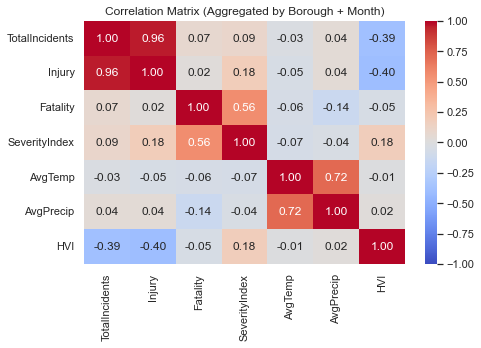

✅ Aggregated Correlation Coefficients:
                TotalIncidents  Injury  Fatality  SeverityIndex  AvgTemp  \
TotalIncidents           1.000   0.961     0.072          0.094   -0.029   
Injury                   0.961   1.000     0.018          0.185   -0.053   
Fatality                 0.072   0.018     1.000          0.557   -0.060   
SeverityIndex            0.094   0.185     0.557          1.000   -0.069   
AvgTemp                 -0.029  -0.053    -0.060         -0.069    1.000   
AvgPrecip                0.043   0.043    -0.136         -0.042    0.716   
HVI                     -0.386  -0.398    -0.053          0.179   -0.008   

                AvgPrecip    HVI  
TotalIncidents      0.043 -0.386  
Injury              0.043 -0.398  
Fatality           -0.136 -0.053  
SeverityIndex      -0.042  0.179  
AvgTemp             0.716 -0.008  
AvgPrecip           1.000  0.016  
HVI                 0.016  1.000  


In [39]:
# %% ============================================================
# 6️⃣ Borough × Month Aggregation
# 按行政区与月份聚合
# ============================================================

group_cols = ["Borough", "Year", "Month"]
agg_dict = {
    "Injury": "sum",
    "Fatality": "sum",
    "SeverityIndex": "mean",
    "AvgTemp": "mean",
    "AvgPrecip": "mean",
    "HVI": "mean"
}

df_region = df.groupby(group_cols).agg(agg_dict).reset_index()
df_region["TotalIncidents"] = df.groupby(group_cols)["Accident Report ID"].count().values

# 计算相关矩阵 correlation
corr_vars = ["TotalIncidents", "Injury", "Fatality", "SeverityIndex", "AvgTemp", "AvgPrecip", "HVI"]
corr = df_region[corr_vars].corr()

plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Matrix (Aggregated by Borough + Month)")
plt.tight_layout()
plt.show()

print("✅ Aggregated Correlation Coefficients:")
print(corr.round(3))

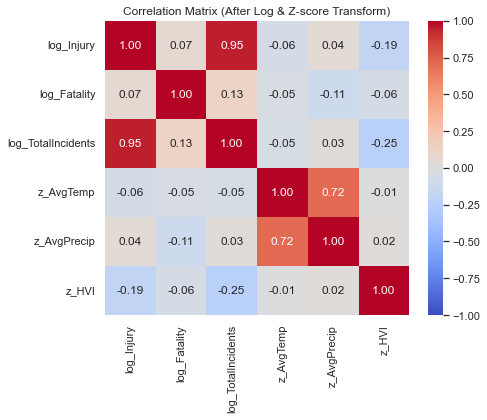

✅ Correlation coefficients after transformation:
                    log_Injury  log_Fatality  log_TotalIncidents  z_AvgTemp  \
log_Injury               1.000         0.066               0.951     -0.065   
log_Fatality             0.066         1.000               0.127     -0.047   
log_TotalIncidents       0.951         0.127               1.000     -0.054   
z_AvgTemp               -0.065        -0.047              -0.054      1.000   
z_AvgPrecip              0.040        -0.113               0.025      0.716   
z_HVI                   -0.190        -0.057              -0.247     -0.008   

                    z_AvgPrecip  z_HVI  
log_Injury                0.040 -0.190  
log_Fatality             -0.113 -0.057  
log_TotalIncidents        0.025 -0.247  
z_AvgTemp                 0.716 -0.008  
z_AvgPrecip               1.000  0.016  
z_HVI                     0.016  1.000  


In [40]:
# %% ============================================================
# 🔁 Distribution Transformation
# 调整变量分布（log / z-score）
# ============================================================

df_corr = df_region.copy()

# 取 log(1+x)
for col in ["Injury", "Fatality", "TotalIncidents"]:
    df_corr[f"log_{col}"] = np.log1p(df_corr[col])

# normalized
for col in ["AvgTemp", "AvgPrecip", "HVI"]:
    df_corr[f"z_{col}"] = (df_corr[col] - df_corr[col].mean()) / df_corr[col].std()

# new correlation matrix
corr_vars = ["log_Injury", "log_Fatality", "log_TotalIncidents", "z_AvgTemp", "z_AvgPrecip", "z_HVI"]
corr = df_corr[corr_vars].corr()

plt.figure(figsize=(7,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Matrix (After Log & Z-score Transform)")
plt.tight_layout()
plt.show()

print("✅ Correlation coefficients after transformation:")
print(corr.round(3))

In [41]:
# %% ============================================================
# 7️⃣ Statistical Modeling (Borough × Month Level)
# Poisson / Negative Binomial 回归模型
# ============================================================

bm = df_region.copy()
bm["logExp"] = np.log(bm["TotalIncidents"].clip(lower=1))

# Poisson 模型（受伤数）
m1 = smf.glm("Injury ~ AvgTemp + HVI + C(Borough)",
             data=bm, family=sm.families.Poisson(), offset=bm["logExp"]).fit()
print("\n📈 Poisson Model: Injury Count")
print(m1.summary())

# Negative Binomial 模型（死亡数）
m2 = smf.glm("Fatality ~ AvgTemp + HVI + C(Borough)",
             data=bm, family=sm.families.NegativeBinomial(), offset=bm["logExp"]).fit()
print("\n💀 Negative Binomial Model: Fatality Count")
print(m2.summary())


📈 Poisson Model: Injury Count
                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Injury   No. Observations:                   93
Model:                            GLM   Df Residuals:                       86
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -177.27
Date:                Sun, 12 Oct 2025   Deviance:                       29.658
Time:                        16:32:00   Pearson chi2:                     28.9
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1284
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------

## 7️⃣ Statistical Modeling (Borough × Month Level)
**Poisson / Negative Binomial 回归模型**

Poisson 模型：
$$
Y_i \sim \text{Poisson}(\mu_i), \quad
\log(\mu_i) = \beta_0 + \beta_1 \text{AvgTemp}_i + 
\beta_2 \text{HVI}_i + 
\sum_k \gamma_k I(\text{Borough}_i=k) + 
\log(\text{Exposure}_i)
$$

Negative Binomial 模型：
$$
Y_i \sim \text{NegBin}(\mu_i, \alpha), \quad
\log(\mu_i) = \beta_0 + \beta_1 \text{AvgTemp}_i + 
\beta_2 \text{HVI}_i + 
\sum_k \gamma_k I(\text{Borough}_i=k) + 
\log(\text{Exposure}_i)
$$

$$
\mathrm{Var}(Y_i) = \mu_i + \alpha \mu_i^2
$$

*References:*  
Hilbe (2011), *Negative Binomial Regression*.  
Cameron & Trivedi (2013), *Regression Analysis of Count Data*.


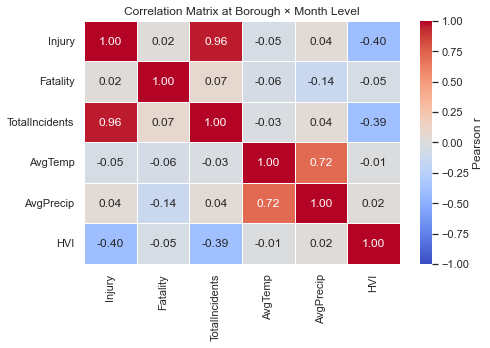

✅ Pearson Correlation Coefficients:
                Injury  Fatality  TotalIncidents  AvgTemp  AvgPrecip    HVI
Injury           1.000     0.018           0.961   -0.053      0.043 -0.398
Fatality         0.018     1.000           0.072   -0.060     -0.136 -0.053
TotalIncidents   0.961     0.072           1.000   -0.029      0.043 -0.386
AvgTemp         -0.053    -0.060          -0.029    1.000      0.716 -0.008
AvgPrecip        0.043    -0.136           0.043    0.716      1.000  0.016
HVI             -0.398    -0.053          -0.386   -0.008      0.016  1.000


In [42]:
# %% ============================================================
# 8️⃣ Correlation Map (Borough × Month Level)
# 模型层级相关矩阵可视化
# ============================================================

corr_vars = ["Injury", "Fatality", "TotalIncidents", "AvgTemp", "AvgPrecip", "HVI"]
corr = bm[corr_vars].corr()

plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1,
            linewidths=0.5, cbar_kws={"label": "Pearson r"})
plt.title("Correlation Matrix at Borough × Month Level")
plt.tight_layout()
plt.show()

print("✅ Pearson Correlation Coefficients:")
print(corr.round(3))

In [43]:
# %% ============================================================
# 9️⃣ Logistic Modeling (Event Level)
# 逻辑回归：预测是否有人受伤/死亡
# ============================================================

df["HasInjury"] = (df["Injury"] > 0).astype(int)
df["HasFatal"]  = (df["Fatality"] > 0).astype(int)

logit_inj = smf.logit("HasInjury ~ AvgTemp + HVI + C(Borough) + C(Month)", data=df).fit()
logit_fat = smf.logit("HasFatal  ~ AvgTemp + HVI + C(Borough) + C(Month)", data=df).fit()

print("\n🩹 Logistic Model: Probability of Injury per Incident")
print(logit_inj.summary())

print("\n⚰️ Logistic Model: Probability of Fatality per Incident")
print(logit_fat.summary())

Optimization terminated successfully.
         Current function value: 0.544219
         Iterations 6
         Current function value: 0.073089
         Iterations: 35

🩹 Logistic Model: Probability of Injury per Incident
                           Logit Regression Results                           
Dep. Variable:              HasInjury   No. Observations:                  949
Model:                          Logit   Df Residuals:                      931
Method:                           MLE   Df Model:                           17
Date:                Sun, 12 Oct 2025   Pseudo R-squ.:                 0.03370
Time:                        16:32:04   Log-Likelihood:                -516.46
converged:                       True   LL-Null:                       -534.48
Covariance Type:            nonrobust   LLR p-value:                  0.004546
                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------

E:\anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The logistic regression model is:

$$
Y_i \sim \text{Bernoulli}(p_i), \quad 
\log\!\left(\frac{p_i}{1 - p_i}\right)
= \beta_0 + \beta_1 \text{AvgTemp}_i +
\beta_2 \text{HVI}_i +
\sum_k \gamma_k I(\text{Borough}_i = k) +
\sum_m \delta_m I(\text{Month}_i = m)
$$

where  
\( p_i = P(Y_i = 1 \mid X_i) \) is the probability of injury or fatality per incident,  
\( \beta, \gamma, \delta \) are regression coefficients estimated via Maximum Likelihood,  
\( \text{AvgTemp}, \text{HVI} \) are continuous predictors,  
\( C(\text{Borough}), C(\text{Month}) \) are categorical dummies.  

**References:**  
Hosmer, D. W., Lemeshow, S., & Sturdivant, R. X. (2013). *Applied Logistic Regression* (3rd ed.). Wiley.  
Cameron, A. C., & Trivedi, P. K. (2013). *Regression Analysis of Count Data* (2nd ed.). Cambridge University Press.


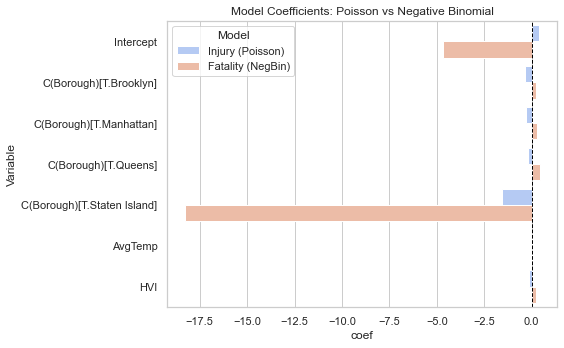

In [44]:
# %% ============================================================
# 🔟 Visualization 1 — Coefficient Plot
# Poisson & NegBin 模型系数对比The logistic regression model is:
# ============================================================

coef_df1 = m1.params.to_frame("coef").reset_index().rename(columns={"index":"Variable"})
coef_df1["Model"] = "Injury (Poisson)"

coef_df2 = m2.params.to_frame("coef").reset_index().rename(columns={"index":"Variable"})
coef_df2["Model"] = "Fatality (NegBin)"

coef_all = pd.concat([coef_df1, coef_df2], ignore_index=True)

plt.figure(figsize=(8,5))
sns.barplot(x="coef", y="Variable", hue="Model", data=coef_all, palette="coolwarm")
plt.axvline(0, color="black", linestyle="--", lw=1)
plt.title("Model Coefficients: Poisson vs Negative Binomial")
plt.tight_layout()
plt.show()

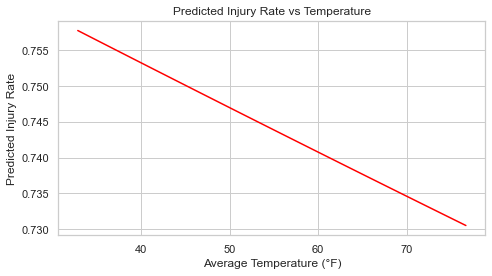

In [45]:
# %% ============================================================
# 1️⃣1️⃣ Visualization 2 — Predicted Injury Rate vs Temperature
# Poisson 模型预测曲线
# ============================================================

temp_range = np.linspace(df["AvgTemp"].min(), df["AvgTemp"].max(), 50)
pred_df = pd.DataFrame({
    "AvgTemp": temp_range,
    "HVI": df["HVI"].mean(),
    "Borough": "Manhattan",
    "logExp": np.log(1)
})
pred_df["PredInjury"] = m1.predict(pred_df)

plt.figure(figsize=(7,4))
sns.lineplot(x="AvgTemp", y="PredInjury", data=pred_df, color="red")
plt.title("Predicted Injury Rate vs Temperature")
plt.xlabel("Average Temperature (°F)")
plt.ylabel("Predicted Injury Rate")
plt.grid(True)
plt.tight_layout()
plt.show()

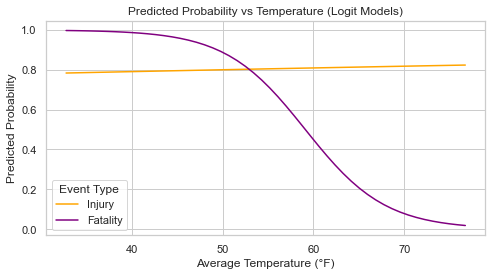

In [46]:
# %% ============================================================
# 1️⃣2️⃣ Visualization 3 — Logistic Models
# 逻辑回归预测概率曲线
# ============================================================

temp_range = np.linspace(df["AvgTemp"].min(), df["AvgTemp"].max(), 50)
pred_df2 = pd.DataFrame({
    "AvgTemp": temp_range,
    "HVI": df["HVI"].mean(),
    "Borough": "Manhattan",
    "Month": 7
})
pred_df2["Prob_Injury"] = logit_inj.predict(pred_df2)
pred_df2["Prob_Fatal"]  = logit_fat.predict(pred_df2)

plt.figure(figsize=(7,4))
sns.lineplot(x="AvgTemp", y="Prob_Injury", data=pred_df2, label="Injury", color="orange")
sns.lineplot(x="AvgTemp", y="Prob_Fatal",  data=pred_df2, label="Fatality", color="purple")
plt.title("Predicted Probability vs Temperature (Logit Models)")
plt.xlabel("Average Temperature (°F)")
plt.ylabel("Predicted Probability")
plt.legend(title="Event Type")
plt.grid(True)
plt.tight_layout()
plt.show()

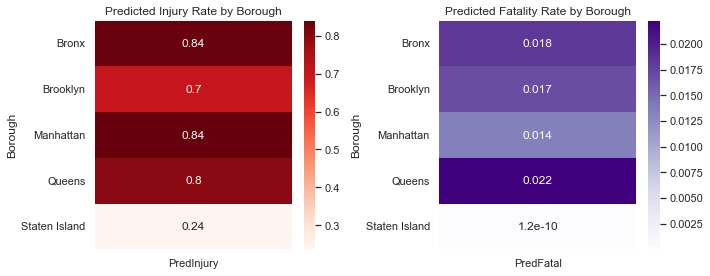

In [47]:
# %% ============================================================
# 1️⃣3️⃣ Visualization 4 — Borough-level Observed vs Predicted
# 各行政区模型预测风险热力图
# ============================================================

df_pred = bm.copy()
df_pred["PredInjury"] = m1.predict(df_pred)
df_pred["PredFatal"]  = m2.predict(df_pred)

pivot_inj = df_pred.pivot_table(index="Borough", values="PredInjury")
pivot_fat = df_pred.pivot_table(index="Borough", values="PredFatal")

fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.heatmap(pivot_inj, annot=True, cmap="Reds", ax=axes[0])
axes[0].set_title("Predicted Injury Rate by Borough")

sns.heatmap(pivot_fat, annot=True, cmap="Purples", ax=axes[1])
axes[1].set_title("Predicted Fatality Rate by Borough")
plt.tight_layout()
plt.show()

# %% ============================================================
# 🧩 Interpretation Note
# ============================================================
# “Spatial effects dominate the model outcomes:
# while temperature and heat vulnerability are not significant,
# borough-level differences explain most variations
# in injury and fatality rates.”

In [48]:
# %%
import pandas as pd
import numpy as np

# 载入事故数据
df = pd.read_csv("Construction_Related_Incidents(Construction-Related_Incidents).csv")
df["Incident Date"] = pd.to_datetime(df["Incident Date"], errors="coerce")
df = df.drop_duplicates(subset=["Accident Report ID"])
df["Year"] = df["Incident Date"].dt.year
df["Month"] = df["Incident Date"].dt.month

# 加载 HVI
hvi = pd.read_csv("Heat_Vulnerability_Index_Rankings.csv")
df["Postcode"] = df["Postcode"].astype(str).str[:5]
hvi["ZIP Code Tabulation Area (ZCTA) 2020"] = hvi["ZIP Code Tabulation Area (ZCTA) 2020"].astype(str).str[:5]
df = pd.merge(
    df, hvi[["ZIP Code Tabulation Area (ZCTA) 2020", "Heat Vulnerability Index (HVI)"]],
    left_on="Postcode", right_on="ZIP Code Tabulation Area (ZCTA) 2020", how="left"
)
df.drop(columns=[c for c in df.columns if "ZIP Code Tabulation Area" in c], inplace=True)
df.rename(columns={"Heat Vulnerability Index (HVI)": "HVI"}, inplace=True)

# 构造严重度指标
df["SeverityIndex"] = 10 * df["Fatality"] + 2 * df["Injury"]
df["SeverityIndex"] = (
    (df["SeverityIndex"] - df["SeverityIndex"].min()) /
    (df["SeverityIndex"].max() - df["SeverityIndex"].min())
)

# 聚合
group_cols = ["Borough", "Year", "Month"]
agg_dict = {
    "Injury": "sum",
    "Fatality": "sum",
    "SeverityIndex": "mean"
}
df_region = df.groupby(group_cols).agg(agg_dict).reset_index()
df_region["TotalIncidents"] = df.groupby(group_cols)["Accident Report ID"].count().values


In [32]:
# %%
import pandas as pd
from IPython.display import display
display(df_region.head(10))
# %%
df_region.to_csv("borough_month_aggregated.csv", index=False)
print("✅ 已导出 borough_month_aggregated.csv")


,Borough,Year,Month,Injury,Fatality,SeverityIndex,TotalIncidents
0,Bronx,2024,1,4,0,0.166667,4
1,Bronx,2024,2,2,0,0.111111,3
2,Bronx,2024,3,6,0,0.166667,6
3,Bronx,2024,4,6,0,0.142857,7
4,Bronx,2024,5,7,0,0.145833,8
5,Bronx,2024,6,9,1,0.233333,10
6,Bronx,2024,7,3,0,0.100000,5
7,Bronx,2024,8,7,0,0.129630,9
8,Bronx,2024,9,4,0,0.133333,5
9,Bronx,2024,10,4,0,0.166667,4


✅ 已导出 borough_month_aggregated.csv
